### __IMPORT LIBRARIES AND LOAD DATA__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2, DenseNet201, InceptionV3, VGG16
from tensorflow.keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load your dataset into a DataFrame
df = pd.read_csv('../data-collection/dataset/skin_disease_dataset.csv')
df.head(5)

,disease_name,body_part,image_path,condition
0,acanthosis-nigricans,arm,../data-collection/dataset/data\acanthosis-nig...,Benign
1,acanthosis-nigricans,arm,../data-collection/dataset/data\acanthosis-nig...,Benign
2,acanthosis-nigricans,feet,../data-collection/dataset/data\acanthosis-nig...,Benign
3,acanthosis-nigricans,folds,../data-collection/dataset/data\acanthosis-nig...,Benign
4,acanthosis-nigricans,folds,../data-collection/dataset/data\acanthosis-nig...,Benign


In [3]:
# Encode labels
le_disease = LabelEncoder()
df['disease_label'] = le_disease.fit_transform(df['disease_name'])

In [4]:
le_effect = LabelEncoder()
df['condition_label'] = le_effect.fit_transform(df['condition'])

### __CHECK FOR DATA IMBALANCE__

In [5]:
class_counts = df['disease_name'].value_counts()
total_instances = len(df)
class_proportions = class_counts / total_instances

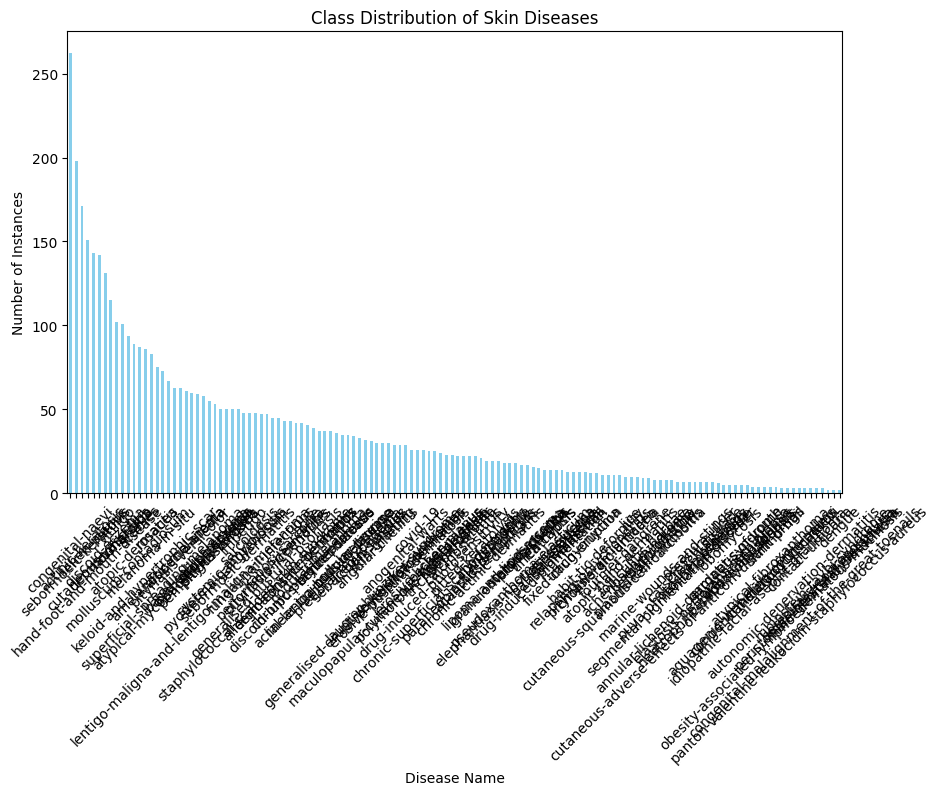

In [6]:
# Plot class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution of Skin Diseases')
plt.xlabel('Disease Name')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Balance the classes
majority_class = class_counts.idxmax()
resampled_dfs = []

for disease_name, count in class_counts.items():
    if disease_name != majority_class:
        df_minority = df[df['disease_name'] == disease_name]
        df_resampled = resample(df_minority, replace=True, n_samples=class_counts[majority_class], random_state=42)
        resampled_dfs.append(df_resampled)
        
df_balanced = pd.concat([df] + resampled_dfs)

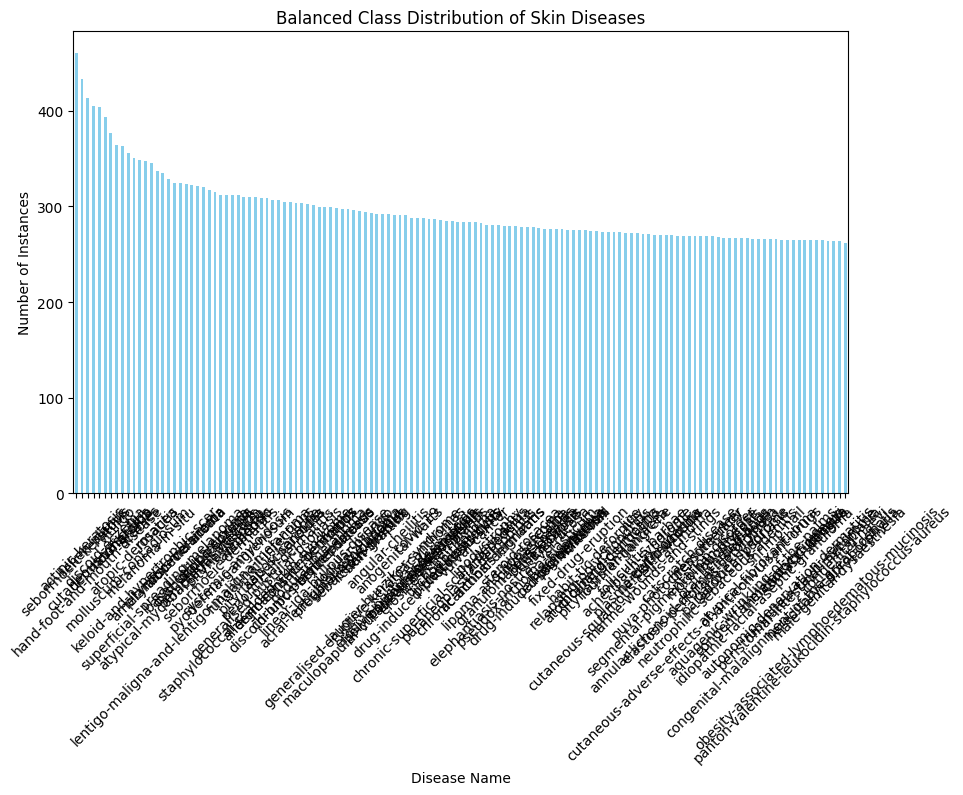

In [8]:
class_counts_balanced = df_balanced['disease_name'].value_counts()

plt.figure(figsize=(10, 6))
class_counts_balanced.plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distribution of Skin Diseases')
plt.xlabel('Disease Name')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.show()

### __DATA AUGMENTATION__

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

In [10]:
# Create training and testing datasets
X = df_balanced['image_path']
y = df_balanced['disease_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### __ENSEMBLE MODEL TRAINING__

In [11]:
train_gen = datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='image_path',
    y_col='disease_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 31728 validated image filenames belonging to 134 classes.


In [12]:
valid_gen = datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='image_path',
    y_col='disease_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 7931 validated image filenames belonging to 134 classes.


In [13]:
# Define input shape
ip_shape = (224, 224, 3)
inputs = Input(shape=ip_shape)

In [14]:
# Load base models
base_model1 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model2 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [15]:
# Freeze base models
base_model1.trainable = False
base_model2.trainable = False
base_model3.trainable = False

In [16]:
# Get output tensors from base models
x1 = base_model1(inputs)
x2 = base_model2(inputs)
x3 = base_model3(inputs)

In [17]:
# Global average pooling for each base model output
x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)
x3 = GlobalAveragePooling2D()(x3)

In [18]:
# Concatenate the outputs
x = Concatenate()([x1, x2, x3])

# Add a fully connected layer and dropout
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

In [19]:
# Add output layer
outputs = Dense(len(set(y_train)), activation='softmax')(x)

In [20]:
# Create the ensemble model
model = Model(inputs=inputs, outputs=outputs)

In [21]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 5, 5, 1536)  54336736    ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 densenet201 (Functional)       (None, 7, 7, 1920)   18321984    ['input_1[0][0]']                
                                                                                              

In [23]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15,
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen)
)

Epoch 1/15
992/992 [==============================] - 524s 477ms/step - loss: 3.5922 - accuracy: 0.1843 - val_loss: 9.9793 - val_accuracy: 0.1239
Epoch 2/15
992/992 [==============================] - 448s 452ms/step - loss: 2.6708 - accuracy: 0.3280 - val_loss: 12.0626 - val_accuracy: 0.1451
Epoch 3/15
992/992 [==============================] - 439s 442ms/step - loss: 2.3916 - accuracy: 0.3813 - val_loss: 13.3288 - val_accuracy: 0.1683
Epoch 4/15
992/992 [==============================] - 439s 443ms/step - loss: 2.2374 - accuracy: 0.4110 - val_loss: 13.4510 - val_accuracy: 0.1808
Epoch 5/15
992/992 [==============================] - 441s 444ms/step - loss: 2.1432 - accuracy: 0.4326 - val_loss: 15.9414 - val_accuracy: 0.1923
Epoch 6/15
992/992 [==============================] - 442s 446ms/step - loss: 2.0607 - accuracy: 0.4476 - val_loss: 19.1628 - val_accuracy: 0.2088
Epoch 7/15
992/992 [==============================] - 442s 445ms/step - loss: 2.0014 - accuracy: 0.4608 - val_loss: 19.

### __MODEL EVALUATION__

In [24]:
# Evaluate the model
y_pred = model.predict(valid_gen)

248/248 [==============================] - 94s 354ms/step


In [25]:
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(valid_gen.classes, y_pred_classes, target_names=valid_gen.class_indices.keys()))

                                                   precision    recall  f1-score   support

                             acanthosis-nigricans       0.00      0.00      0.00        19
                               achenbach-syndrome       0.00      0.00      0.00        10
                                             acne       0.01      0.02      0.01        41
                       acral-lentiginous-melanoma       0.00      0.00      0.00        37
                                actinic-keratosis       0.00      0.00      0.00       433
                      allergic-contact-dermatitis       0.00      0.00      0.00        43
                                  alopecia-areata       0.00      0.00      0.00        61
                              amelanotic-melanoma       0.01      0.07      0.02        67
                                       angioedema       0.00      0.00      0.00        19
                                angular-cheilitis       0.00      0.00      0.00        3

c:\Users\prais\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prais\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prais\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

### __SAVE MODEL__

In [26]:
# Save the model
model.save('best_model_1.h5')